In [1]:
#LSTM
"""NOTES: Batch data is different each time in keras, which result in slight differences in results."""
"""
" Bettycxh, "Toward-Sleep-Apnea-Detection-with-Lightweight-Multi-scaled-Fusion-Network," GitHub repository, n.d. [Online]. 
Availab   le: https://github.com/Bettycxh/Toward-Sleep-Apnea-Detection-with-Lightweight-Multi-scaled-Fusion-Network
"""
import pickle
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.callbacks import LearningRateScheduler
# 设置随机种子
# tf.random.set_seed(42)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.Session(config=config).close()

2024-11-02 21:05:51.514068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

from keras.layers import BatchNormalization, LeakyReLU, MaxPooling1D, Dropout, Flatten, Dense, Conv1D,Reshape,multiply,GlobalAveragePooling1D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.regularizers import l2
from scipy.interpolate import splev, splrep
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
base_dir = "/home/pugongying/data/jupyterLab/new_dev/lxx/MPCNN-Sleep-Apnea-main/dataset"

ir = 3 # interpolate interval
before = 2
after = 2

# normalize
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [4]:
from scipy.interpolate import CubicSpline
def interpolate_numpy_array(arr, desired_length):
    cs = CubicSpline(np.linspace(0, 1, len(arr)), arr)
    x_new = np.linspace(0, 1, desired_length)
    interpolated_arr = cs(x_new)
    return interpolated_arr

In [5]:
import random
def load_data():
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))
    with open(os.path.join(base_dir, "T_1.pkl"), 'rb') as f: # read preprocessing result
        apnea_ecg = pickle.load(f)
    x_train1,x_train2,x_train3 = [],[],[]
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]
    groups_train = apnea_ecg["groups_train"]
    for i in range(len(o_train)):
        min_distance_list, max_distance_list, mean_distance_list = o_train[i]
		# Curve interpolation
        min_distance_list_inter = interpolate_numpy_array(min_distance_list,900)
        max_distance_list_inter = interpolate_numpy_array(max_distance_list,900)
        mean_distance_list_inter = interpolate_numpy_array(mean_distance_list,900)
# """
# In this part we design the ablation to test the relationship of each terms: MinDP,MaxDP, MeanDP. By add this value in
# the list x_train1,x_train2,x_train3 we can represent all the case in the paper including: M1,M2,M3,M4,M5,M6,M7.
# MinDP: min_distance_list_inter
# MaxDP: max_distance_list_inter
# MeanDP: mean_distance_list_inter
# """
        x_train1.append([min_distance_list_inter, max_distance_list_inter])
        x_train2.append([min_distance_list_inter[180:720], max_distance_list_inter[180:720]])
        x_train3.append([min_distance_list_inter[360:540], max_distance_list_inter[360:540]])
    x_training1,x_training2,x_training3,y_training,groups_training = [],[],[],[],[]
    x_val1,x_val2,x_val3,y_val,groups_val = [],[],[],[],[]

    trainlist = random.sample(range(len(o_train)),int(len(o_train)*0.7))
    num=[i for i in range(16713)]
    vallist = set(num) - set(trainlist)
    vallist = list(vallist)
    for i in trainlist:
        x_training1.append(x_train1[i])
        x_training2.append(x_train2[i])
        x_training3.append(x_train3[i])
        y_training.append(y_train[i])
        groups_training.append(groups_train[i])
    for i in vallist:
        x_val1.append(x_train1[i])
        x_val2.append(x_train2[i])
        x_val3.append(x_train3[i])
        y_val.append(y_train[i])
        groups_val.append(groups_train[i])

    #np.array()将这些列表转换为Numpy数组，然后使用transpose()函数对这些数组进行维度转置。
    #原数组的第一个维度保持不变（0），第二个和第三个交换位置。这将原数组的第二个维度（时间步长）和第三个维度（通道数）进行了交换。
    x_training1 = np.array(x_training1, dtype="float32").transpose((0, 2, 1))
    x_training2 = np.array(x_training2, dtype="float32").transpose((0, 2, 1))
    x_training3 = np.array(x_training3, dtype="float32").transpose((0, 2, 1))
    y_training = np.array(y_training, dtype="float32")
    x_val1 = np.array(x_val1, dtype="float32").transpose((0, 2, 1))
    x_val2 = np.array(x_val2, dtype="float32").transpose((0, 2, 1))
    x_val3 = np.array(x_val3, dtype="float32").transpose((0, 2, 1))
    y_val = np.array(y_val, dtype="float32")

    x_test1,x_test2,x_test3 = [],[],[]
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]
    groups_test = apnea_ecg["groups_test"]
    for i in range(len(o_test)):
        min_distance_list, max_distance_list, mean_distance_list = o_test[i]
		# Curve interpolation
        min_distance_list_inter = interpolate_numpy_array(min_distance_list,900)
        max_distance_list_inter = interpolate_numpy_array(max_distance_list,900)
        mean_distance_list_inter = interpolate_numpy_array(mean_distance_list,900)
        x_test1.append([min_distance_list_inter, max_distance_list_inter])
        x_test2.append([min_distance_list_inter[180:720], max_distance_list_inter[180:720]])
        x_test3.append([min_distance_list_inter[360:540], max_distance_list_inter[360:540]])
    x_test1 = np.array(x_test1, dtype="float32").transpose((0, 2, 1))
    x_test2 = np.array(x_test2, dtype="float32").transpose((0, 2, 1))
    x_test3 = np.array(x_test3, dtype="float32").transpose((0, 2, 1))
    y_test = np.array(y_test, dtype="float32")

    return x_training1, x_training2, x_training3, y_training, groups_training, x_val1, x_val2, x_val3, y_val, groups_val, x_test1, x_test2, x_test3, y_test, groups_test


改动

In [6]:
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, ratio=4,**kwargs):
        super(ChannelAttention, self).__init__()
        self.ratio = ratio

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.fc1 = tf.keras.layers.Dense(self.channels // self.ratio, activation='relu')
        self.fc2 = tf.keras.layers.Dense(self.channels, activation='sigmoid')

    def call(self, inputs):
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = self.fc1(max_pool)
        avg_pool = self.fc1(avg_pool)
        attention = self.fc2(tf.keras.layers.add([max_pool, avg_pool]))
        return inputs * attention

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7,**kwargs):
        super(SpatialAttention, self).__init__()
        self.conv = tf.keras.layers.Conv1D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        attention = tf.concat([max_pool, avg_pool], axis=-1)
        attention = self.conv(attention)
        return inputs * attention

class CBAM(tf.keras.layers.Layer):
    def __init__(self, ratio=4, kernel_size=7,**kwargs):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def call(self, inputs):
        x = self.channel_attention(inputs)
        x = self.spatial_attention(x)
        return x

In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


#### 残差注意力

In [8]:
#更注重于局部特征的提取和注意力计算
import tensorflow as tf
class ResidualAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, num_input_features, num_output_features):
        super(ResidualAttentionBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv1D(num_output_features, kernel_size=1, strides=1, padding='valid', use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1D(num_output_features, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv1D(num_output_features, kernel_size=1, strides=1, padding='valid', use_bias=False)
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, x):
        residual = x       

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.sigmoid(out)       #输出限制到0~1

        out = out * residual + residual

        return out


#### 多头注意力

In [9]:
class MultiheadAttention(tf.keras.layers.Layer):
    def __init__(self, emb_dim, head_num, scaling=True):
        super(MultiheadAttention, self).__init__()
        self.emb_dim = emb_dim
        self.head_num = head_num
        self.scaling = scaling
        self.att_emb_size = emb_dim // head_num
        assert emb_dim % head_num == 0, "emb_dim must be divisible head_num"

        self.W_Q = self.add_weight(shape=(emb_dim, emb_dim),
                                   initializer='glorot_uniform',
                                   trainable=True)
        self.W_K = self.add_weight(shape=(emb_dim, emb_dim),
                                   initializer='glorot_uniform',
                                   trainable=True)
        self.W_V = self.add_weight(shape=(emb_dim, emb_dim),
                                   initializer='glorot_uniform',
                                   trainable=True)

    def call(self, inputs):
        querys = tf.tensordot(inputs, self.W_Q, axes=[-1, 0])
        keys = tf.tensordot(inputs, self.W_K, axes=[-1, 0])
        values = tf.tensordot(inputs, self.W_V, axes=[-1, 0])

        querys = tf.stack(tf.split(querys, self.head_num, axis=2))
        keys = tf.stack(tf.split(keys, self.head_num, axis=2))
        values = tf.stack(tf.split(values, self.head_num, axis=2))

        inner_product = tf.matmul(querys, tf.transpose(keys, perm=[0, 1, 3, 2]))
        if self.scaling:
            inner_product /= tf.sqrt(tf.cast(self.att_emb_size, tf.float32))

        attn_w = tf.nn.softmax(inner_product, axis=-1)
        results = tf.matmul(attn_w, values)

        # Merge heads
        results = tf.transpose(results, perm=[0, 2, 1, 3])
        results = tf.reshape(results, (-1, tf.shape(results)[1], self.emb_dim))

        return results



### transformer

In [10]:
#更侧重于对整个序列的语义信息的编码和解码
from tensorflow.keras import layers
class Transformer(tf.keras.Model):
    def __init__(self, num_layers=2, d_model=64, nhead=1, dim_feedforward=128, dropout=0.30):
        super(Transformer, self).__init__()
         # 稠密层，用于将输入数据映射到 d_model 维度
        self.precnnlayer = layers.Dense(d_model)
        
        # 定义多头自注意力层，帮助模型捕捉序列中的长距离依赖关系
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=nhead, key_dim=d_model)
        
        # 前馈神经网络，用于处理每个位置的特征
        self.ffn = tf.keras.Sequential([
            layers.Dense(dim_feedforward, activation='relu'),
            layers.Dense(d_model)
        ])
        
        # 两个归一化层
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        #Dropout层，用于正则化
        self.dropout = layers.Dropout(dropout)
        
        #最后的预测层，输出最终的类别概率分布
        self.pred_layer = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(2, activation='softmax')
        ])
        
    def call(self, x):
        x = self.precnnlayer(x)
        x += self.multi_head_attention(x, x)
        x = self.dropout(x)
        x = self.layer_norm1(x)
        ffn_output = self.ffn(x)
        #残差连接
        x += ffn_output
        x = self.dropout(x)
        x = self.layer_norm2(x)
        x = tf.reduce_mean(x, axis=1)
        x = self.pred_layer(x)
        return x


### LSTM

In [11]:

import tensorflow as tf

class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, dropouti=0., dropoutw=0., dropouto=0., unit_forget_bias=True, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units  #LSTM单元的数量
        self.dropouti = dropouti   #输入dropout比率，默认为0
        self.dropoutw = dropoutw   #权重dropout比率，默认为0
        self.dropouto = dropouto   #输出dropout比率，默认为0
        self.unit_forget_bias = unit_forget_bias   #是否使用单元偏置，默认为True
        self.return_sequences = return_sequences   #是否返回序列，默认为False
        ## 创建LSTM单元和dropout层
        self.lstm_cell = tf.keras.layers.LSTMCell(units, unit_forget_bias=unit_forget_bias)
        self.input_drop = tf.keras.layers.Dropout(dropouti)
        self.output_drop = tf.keras.layers.Dropout(dropouto)
        # 创建内置的LSTM层
        self.lstm = tf.keras.layers.LSTM(units, return_sequences=return_sequences, dropout=dropouti, recurrent_dropout=dropoutw, unit_forget_bias=unit_forget_bias)

    #构建LSTM层的权重
    def build(self, input_shape):
        #初始化输出门权重
        self._kernel_hh = self.add_weight(shape=(4 * self.units, self.units),  #用于隐藏状态的核矩阵，计算前一时刻的隐藏状态对当前时刻的影响，将上一个时间步的隐藏状态与当前输入进行变换
                                           initializer='orthogonal',
                                           name='kernel_hh')
        #初始化输入门和遗忘门的权重
        self._kernel_ih = self.add_weight(shape=(4 * self.units, input_shape[-1]),  #用于输入的核矩阵，计算当前时刻的输入对当前时刻状态的影响，将输入数据与当前隐藏状态进行变换，以更新当前时刻的状态
                                           initializer='glorot_uniform',
                                           name='kernel_ih')
        ## 如果使用了单元偏置，则设置偏置值
        if self.unit_forget_bias:
            self._bias = self.add_weight(shape=(4 * self.units,),
                                         initializer='zeros',
                                         name='bias')
            self._bias[self.units:2 * self.units].assign(tf.constant(1.0, shape=(self.units,)))
        else:
            self._bias = self.add_weight(shape=(4 * self.units,),
                                         initializer='zeros',
                                         name='bias')

    def call(self, inputs, training=None):
        self._drop_weights(training)
        inputs = self.input_drop(inputs, training=training)
        outputs = self.lstm(inputs, training=training)
        # 如果需要返回序列，则对输出进行dropout处理
        if self.return_sequences:
            outputs = self.output_drop(outputs, training=training)
        return outputs


    def _drop_weights(self, training):
        if training:
            # 对输入到LSTM单元的输入权重和循环权重进行dropout处理
            self.lstm_cell.kernel = tf.keras.backend.dropout(self._kernel_ih, level=self.dropoutw)
            self.lstm_cell.recurrent_kernel = tf.keras.backend.dropout(self._kernel_hh, level=self.dropoutw)


In [12]:
# class SpatialAttention(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(SpatialAttention, self).__init__(**kwargs)
#         self.conv = tf.keras.layers.Conv1D(1, 3, padding='same')
#         self.activation = tf.keras.layers.Activation('sigmoid')

#     def call(self, inputs):
#         weights = self.conv(inputs)
#         weights = self.activation(weights)
#         return tf.multiply(inputs, weights)

In [13]:
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, ratio=4,**kwargs):
        super(ChannelAttention, self).__init__()
        self.ratio = ratio

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.fc1 = tf.keras.layers.Dense(self.channels // self.ratio, activation='relu')
        self.fc2 = tf.keras.layers.Dense(self.channels, activation='sigmoid')

    def call(self, inputs):
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = self.fc1(max_pool)
        avg_pool = self.fc1(avg_pool)
        attention = self.fc2(tf.keras.layers.add([max_pool, avg_pool]))
        return inputs * attention

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7,**kwargs):
        super(SpatialAttention, self).__init__()
        self.conv = tf.keras.layers.Conv1D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        attention = tf.concat([max_pool, avg_pool], axis=-1)
        attention = self.conv(attention)
        return inputs * attention

class CBAM(tf.keras.layers.Layer):
    def __init__(self, ratio=4, kernel_size=7,**kwargs):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def call(self, inputs):
        x = self.channel_attention(inputs)
        x = self.spatial_attention(x)
        return x

In [21]:
from keras.layers import AveragePooling1D
from tensorflow.keras.layers import Input, BatchNormalization, GRU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow import keras

from keras.layers import BatchNormalization, LeakyReLU, MaxPooling1D, Dropout, Flatten, Dense, Conv1D,Reshape,multiply,GlobalAveragePooling1D

def create_model(input_a_shape, input_b_shape, input_c_shape, weight=1e-3,rate=1):
# def create_model(input_a_shape, weight=1e-3,rate=1):
    leaky_relu = LeakyReLU()
    # relu=ReLU()
    
    # SA-CNN-3（5分钟）
    input1 = Input(shape=input_a_shape)
     # Conv1
    x1 = BatchNormalization()(input1)    
    x1 = Conv1D(96, kernel_size=11, strides=4, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x1)
   
    # x1=LSTM(16, activation='tanh' , kernel_regularizer=l2(0.2),return_sequences=True)(x1)
    
    x1 = leaky_relu(x1)
    x1 = MaxPooling1D(pool_size=3, padding="same")(x1)
    x1 = Dropout(0.5)(x1)

    # Conv2
    x1 = Conv1D(256, kernel_size=7, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x1)
    
    # x1=LSTM(32, activation='tanh' ,return_sequences=True, kernel_regularizer=l2(0.2))(x1)
    x1 = BatchNormalization()(x1)
    x1 = leaky_relu(x1)
    x1 = MaxPooling1D(pool_size=3,strides=2, padding="same")(x1)
    x1 = Dropout(0.5)(x1)

    # Conv3
    x1 = Conv1D(384, kernel_size=5, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x1)
    
    # x1=LSTM(64, activation='tanh' ,return_sequences=True, kernel_regularizer=l2(0.2))(x1)
    x1 = BatchNormalization()(x1)
    x1 = leaky_relu(x1)
    x1 = MaxPooling1D(pool_size=2, padding="same")(x1)
    x1 = Dropout(0.5)(x1)

    # Conv4
    x1 = Conv1D(384, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x1)
    
    # x1=LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.2))(x1)
    x1 = BatchNormalization()(x1)
    x1 = leaky_relu(x1)
    x1 = MaxPooling1D(pool_size=2, padding="same")(x1)
    # x1 = CustomLSTM(16, return_sequences=True)(x1)
    x1 = Dropout(0.5)(x1)

    # Conv5
    x1 = Conv1D(256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x1)
    
    # x1=LSTM(256, activation='tanh' ,return_sequences=True, kernel_regularizer=l2(0.2))(x1)
    x1 = BatchNormalization()(x1)
    x1 = leaky_relu(x1)   
    x1 = MaxPooling1D(pool_size=2, padding="same")(x1)
    # x1 = LSTM(256, return_sequences=True)(x1)  # Adjust the number of units as needed
    # x1 = CustomLSTM(384, return_sequences=True)(x1)
    x1 = Dropout(0.5)(x1)
    
    # x1 = BatchNormalization()(x1)
    # x1=LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.1))(x1)
    # x1 = Dropout(0.5)(x1)
    # x1 = BatchNormalization()(x1)
    # x1=LSTM(256, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.1))(x1)
    # x1 = Dropout(0.5)(x1)

    # SA-CNN-2（3分钟）
    input2 = Input(shape=input_b_shape)
    x2 = BatchNormalization()(input2)
    # Conv1
    x2 = Conv1D(16, kernel_size=9, strides=4, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x2)
    
    x2 = leaky_relu(x2)
    x2 = MaxPooling1D(pool_size=3)(x2)
    x2 = Dropout(0.5)(x2)

    # Conv2
    x2 = Conv1D(32, kernel_size=5, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x2)
    x2 = BatchNormalization()(x2)
    x2 = leaky_relu(x2)
    x2 = MaxPooling1D(pool_size=3)(x2)
    x2 = Dropout(0.5)(x2)

    # Conv3
    x2 = Conv1D(64, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x2)
    x2 = BatchNormalization()(x2)
    x2 = leaky_relu(x2)
    x2 = Dropout(0.5)(x2)

    # Conv4
    x2 = Conv1D(128, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x2)
    x2 = BatchNormalization()(x2)
    x2 = leaky_relu(x2)
    # x2 = CustomLSTM(16, return_sequences=True)(x2)
    x2 = Dropout(0.5)(x2)

    # Conv5
    x2 = Conv1D(256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x2)
    x2 = BatchNormalization()(x2)
    x2 = leaky_relu(x2)   
    x2 = MaxPooling1D(pool_size=3)(x2)    
    # x2 = LSTM(256, return_sequences=True)(x2)  # Adjust the number of units as needed 
    # x2 = CustomLSTM(384, return_sequences=True)(x2)
    x2 = Dropout(0.5)(x2)
    
    # x2 = BatchNormalization()(x2)
    # x2=LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.1))(x2)
    # x2 = Dropout(0.5)(x2)
    # x2 = BatchNormalization()(x2)
    # x2=LSTM(256, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.1))(x2)
    # x2 = Dropout(0.5)(x2)
    

    # SA-CNN-1（1分钟）
    input3 = Input(shape=input_c_shape)
    # x3 = Conv1D(16, kernel_size=11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
    #             kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(input3)
    # x3 = Conv1D(24, kernel_size=11, strides=2, padding="same", activation="relu", kernel_initializer="he_normal",
    #             kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x3)
    # x3 = MaxPooling1D(pool_size=3, padding="same")(x3)
    # x3 = Conv1D(32, kernel_size=1, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
    #             kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x3)
    # x3 = MaxPooling1D(pool_size=6, padding="same")(x3)
    # Conv1
    x3 = Conv1D(16, kernel_size=7, strides=4, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(input3)
    x3 = BatchNormalization()(x3)
    x3 = leaky_relu(x3)
    x3 = MaxPooling1D(pool_size=3)(x3)
    x3 = Dropout(0.5)(x3)

    # Conv2
    x3 = Conv1D(32, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x3)
    x3 = BatchNormalization()(x3)
    x3 = leaky_relu(x3)
    x3 = MaxPooling1D(pool_size=3)(x3)
    x3 = Dropout(0.5)(x3)

    # Conv3
    x3 = Conv1D(64, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x3)
    x3 = BatchNormalization()(x3)
    x3 = leaky_relu(x3)
    x3 = Dropout(0.5)(x3)

#     # Conv4
#     x3 = Conv1D(128, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
#                kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x3)
#     x3 = BatchNormalization()(x3)
#     x3 = leaky_relu(x3)
#     # x3 = CustomLSTM(16, return_sequences=True)(x3)
#     x3 = Dropout(0.5)(x3)

#     # Conv5
#     x3 = Conv1D(256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
#                kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x3)
#     x3 = BatchNormalization()(x3)
#     x3 = leaky_relu(x3)  
#     # x3 = MaxPooling1D(pool_size=3)(x3)   
#     # x3 = LSTM(256, return_sequences=True)(x3)  # Adjust the number of units as needed
#     # x3 = CustomLSTM(384, return_sequences=True)(x3)
#     x3 = Dropout(0.5)(x3)


     # 创建残差注意力块
    attention1 = ResidualAttentionBlock(256, 256)
    attention2 = ResidualAttentionBlock(64, 64)
    # 将注意力应用于输入数据
    x1 = attention1(x1)
    x2 = attention1(x2)
    x3 = attention2(x3)
    
    # 通道注意力模块，基于注意力机制的特征增强，捕捉输入数据中的重要信息
    concat = keras.layers.concatenate([x1, x2, x3], name="Concat_Layer", axis=-1)  
    concat=ChannelAttention()(concat)
    x = GlobalAveragePooling1D()(concat)
    dp = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax', name="Output_Layer")(dp)
    model = Model(inputs=[input1, input2, input3], outputs=outputs)
    # model = Model(inputs=input1, outputs=outputs)
    return model


In [16]:
def lr_schedule(epoch, lr):
    if epoch > 70 and \
            (epoch - 1) % 10 == 0:
        lr *= 0.1
    print("Learning rate: ", lr)
    return lr

In [17]:
def plot(history):
    """Plot performance curve"""
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")
    fig.tight_layout()
    plt.show()

In [18]:
from keras import optimizers
if __name__ == "__main__":

    x_train1, x_train2, x_train3, y_train, groups_train, x_val1, x_val2, x_val3, y_val, groups_val, x_test1, x_test2, x_test3, y_test, groups_test= load_data()

    y_train = keras.utils.to_categorical(y_train, num_classes=2)  # Convert to two categories
    y_val = keras.utils.to_categorical(y_val, num_classes=2)
    y_test = keras.utils.to_categorical(y_test, num_classes=2)

    print('input_shape', x_train1.shape, x_train2.shape, x_train3.shape)

input_shape (11699, 900, 2) (11699, 540, 2) (11699, 180, 2)


In [19]:

print(len(y_train))

11699


In [22]:
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, f1_score,roc_auc_score
from tensorflow.keras.optimizers import Adam
model = create_model(x_train1.shape[1:], x_train2.shape[1:], x_train3.shape[1:])
model.summary()

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

lr_scheduler = LearningRateScheduler(lr_schedule) # Dynamic adjustment learning rate
history = model.fit([x_train1, x_train2, x_train3], y_train, batch_size=128, epochs=100, validation_data=([x_val1, x_val2, x_val3], y_val),
                        callbacks=[lr_scheduler])


# evaluate the model
loss, accuracy = model.evaluate([x_test1, x_test2, x_test3], y_test)
print("Test loss: ", loss)
print("Accuracy: ", accuracy)

# print accuracy, sensitivity, specificity, and F1 score for both training and testing data
print("Testing:")
y_true, y_pred = y_test.argmax(axis=-1), np.argmax(model.predict([x_test1, x_test2, x_test3], batch_size=1024, verbose=1), axis=-1)
y_true = to_categorical(y_true, num_classes=2)  # Convert y_true to binary label indicators
C = confusion_matrix(y_true[:, 1], y_pred, labels=(1, 0))  # Use y_true[:, 1] as binary label indicators for class 1
TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
precision = TP / (TP + FP)
recall = sn  # Recall is equivalent to sensitivity
f1 = 2 * (precision * recall) / (precision + recall)
print("TP:{}, TN:{}, FP:{}, FN:{}, loss{}, acc{}, sn{}, sp{}, f1{}".format(TP, TN, FP, FN,loss, acc, sn, sp, f1))




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 900, 2)]     0           []                               
                                                                                                  
 batch_normalization_19 (BatchN  (None, 900, 2)      8           ['input_4[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv1d_19 (Conv1D)             (None, 225, 96)      2208        ['batch_normalization_19[0][0]'] 
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)      multiple             0           ['conv1d_19[0][0]',          

In [ ]:
# #save model 
# y_score = model.predict([x_test1, x_test2, x_test3])
# output = pd.DataFrame({"y_true": y_test[:, 1], "y_score": y_score[:, 1], "subject": groups_test})
# output.to_csv("/home/pugongying/data/jupyterLab/new_dev/lxx/MPCNN-Sleep-Apnea-main/output/resi_chan.csv", index=False)

In [ ]:
# from tensorflow.keras.models import load_model
# from CustomLSTM import CustomLSTM  # 假设你的自定义层在 custom_layers.py 中
# model.save_weights('./best_weights_ecg_32layer_resi_chan.hdf5')
# model.load_weights('./best_weights_ecg_32layer_resi_chan.hdf5')

# model_test = create_model(x_train1.shape[1:], x_train2.shape[1:], x_train3.shape[1:])
# # 加载模型权重
# model_test.load_weights('./best_weights_ecg_32layer_resi_chan.hdf5')

# y_true, y_pred = y_test.argmax(axis=-1), np.argmax(model_test.predict([x_test1, x_test2, x_test3], batch_size=1024, verbose=1), axis=-1)
# y_true = to_categorical(y_true, num_classes=2)  # Convert y_true to binary label indicators
# C = confusion_matrix(y_true[:, 1], y_pred, labels=(1, 0))  # Use y_true[:, 1] as binary label indicators for class 1
# TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
# acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
# precision = TP / (TP + FP)
# recall = sn  # Recall is equivalent to sensitivity
# f1 = 2 * (precision * recall) / (precision + recall)
# print("TP:{}, TN:{}, FP:{}, FN:{}, loss{}, acc{}, sn{}, sp{}, f1{}".format(TP, TN, FP, FN,loss, acc, sn, sp, f1))

In [ ]:
# # loss = history.history['loss']
# # val_loss = history.history['val_loss']

# # acc=history.history['accuracy']
# # val_acc=history.history['val_accuracy']

# # plt.figure(figsize=(6,12))

# # plt.subplot(2,1,1)

# # plt.xlabel('Epochs')
# # plt.ylabel('Loss')
# # plt.plot(loss, 'blue', label='Training Loss')
# # plt.plot(val_loss, 'green', label='Validation Loss')
# # plt.xticks(range(0,epochs)[0::100])
# # plt.title('Training and Validation Loss vs Epochs')
# # plt.legend()

# # plt.subplot(2,1,2)

# # plt.xlabel('Epochs')
# # plt.ylabel('Accuracy')
# # plt.plot(acc, 'blue', label='Training Accuracy')
# # plt.plot(val_acc, 'green', label='Validation Accuracy')
# # plt.xticks(range(0,epochs)[0::100])
# # plt.title('Training and Validation Accuracy vs Epochs')
# # plt.legend()
# # plt.savefig("SE-MSCNN.svg")
# # plt.show()

# # Plot loss and accuracy curves
# history.history['val_loss'], label=plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot('Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss Curves')
# plt.savefig('/home/pugongying/data/jupyterLab/new_dev/lxx/MPCNN-Sleep-Apnea-main/residual/loss_curve.png')  # Save loss curve
# plt.legend()


# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Curves')
# plt.savefig('/home/pugongying/data/jupyterLab/new_dev/lxx/MPCNN-Sleep-Apnea-main/residual/accuracy_curve.png')  # Save accuracy curve
# plt.legend()
# plt.show()

In [ ]:
import lime  
import lime.lime_tabular  
  
# 假设您已经有一个加载并训练好的模型，以及相应的测试数据  
# 这里我们假设只使用x_test1作为输入  
  
# 选择一个要解释的样本索引  
sample_index = 0  
x_train1_flat = x_train1.reshape(x_train1.shape[0], -1)  # 假设你想要将 (900, 2) 扁平化为 1800 个特征  
# LIME需要原始数据来训练其局部解释模型  
# 这里我们使用x_train1作为背景数据集（注意：这可能需要是代表性的样本集）  
background_data = x_train1_flat  
  
# 创建一个LIME解释器  
# 注意：对于非表格数据（如图像或文本），您可能需要使用不同的LIME解释器（如lime_image或lime_text）  
# 但由于您提到的是多输入数组，这里我们假设x_test1是表格数据（或可以转换为表格数据）  
explainer = lime.lime_tabular.LimeTabularExplainer(  
    training_data=background_data,  
    feature_names=[f'feature_{i+1}' for i in range(x_train1_flat.shape[1])],  # 假设您有一个包含特征名称的列表  
    class_names=['class0', 'class1'],  # 假设您的模型是一个二分类模型  
    mode='classification'  
)  
print(1)
x_test1_flat=x_test1.reshape(x_test1.shape[0], -1) 
# 使用LIME解释器来解释特定样本的预测  
exp = explainer.explain_instance(x_test1_flat[sample_index], model.predict, num_features=10)  
print(1)
# 显示解释  
exp.show_in_notebook(show_table=True, show_all=False)  
  
# 或者，如果您想以编程方式访问解释  
exp.as_list()  # 返回一个包含特征名称、权重和正/负指示的列表

In [ ]:
print(y_train)

/home/pugongying/anaconda3/envs/gcn/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/pugongying/anaconda3/envs/gcn/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


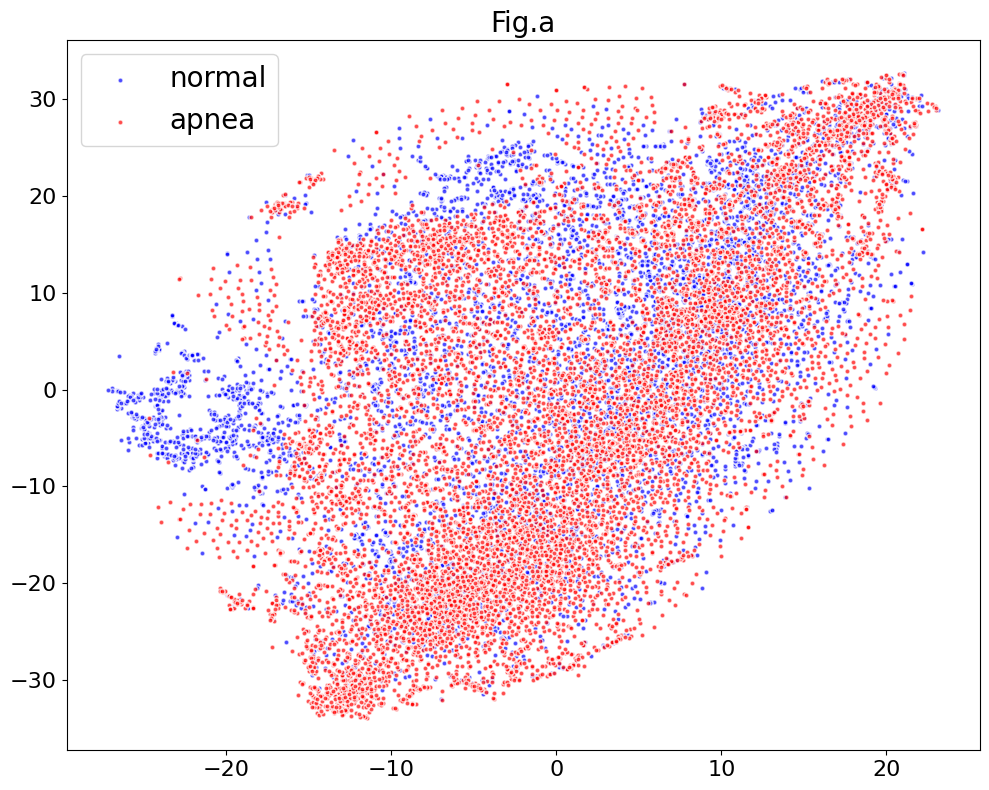

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Step 2: 将数据降至二维
data_flat = np.reshape(x_test1, (x_test1.shape[0], -1))

# Step 3: 将多维标签数组转换成一维数组，并将每个标签表示为字符串
labels_str = []
for label in y_test:
    if label[0] == 0 and label[1] == 1:
        labels_str.append('normal')
    elif label[0] == 1 and label[1] == 0:
        labels_str.append('apnea')
    else:
        # 处理未知标签情况
        labels_str.append('Unknown')

# 转换为 NumPy 数组
labels_str = np.array(labels_str)

# Step 4: 应用 t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_flat)

# Step 5: 绘制散点图
plt.figure(figsize=(10, 8))
plt.scatter(data_tsne[labels_str == 'normal', 0], data_tsne[labels_str == 'normal', 1], color='blue', label='normal',  marker='.', alpha=0.7, s=50, edgecolors='white')
plt.scatter(data_tsne[labels_str == 'apnea', 0], data_tsne[labels_str == 'apnea', 1], color='red', label='apnea',  marker='.', alpha=0.7, s=50, edgecolors='white')
# plt.title("Results with SFE-CBAM(b)", fontsize=20)
plt.title("Fig.a", fontsize=20)
plt.legend(fontsize=20)
# plt.xlabel('Feature dimension 1', fontsize=20)          # 设置x轴标签字体大小
# plt.ylabel('Feature dimension 2', fontsize=20)       # 设置y轴标签字体大小
# plt.xlim(-60,80)
# plt.ylim(-60,80)
# 设置x轴和y轴刻度的字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('resultWithModel.png')
# plt.savefig('resultWithoutModel.png')
# plt.savefig('figa.pdf', format='pdf')
# plt.savefig('resultWithModel.pdf', format='pdf')
plt.show()


530/530 [==============================] - 3s 4ms/step


/home/pugongying/anaconda3/envs/gcn/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/pugongying/anaconda3/envs/gcn/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


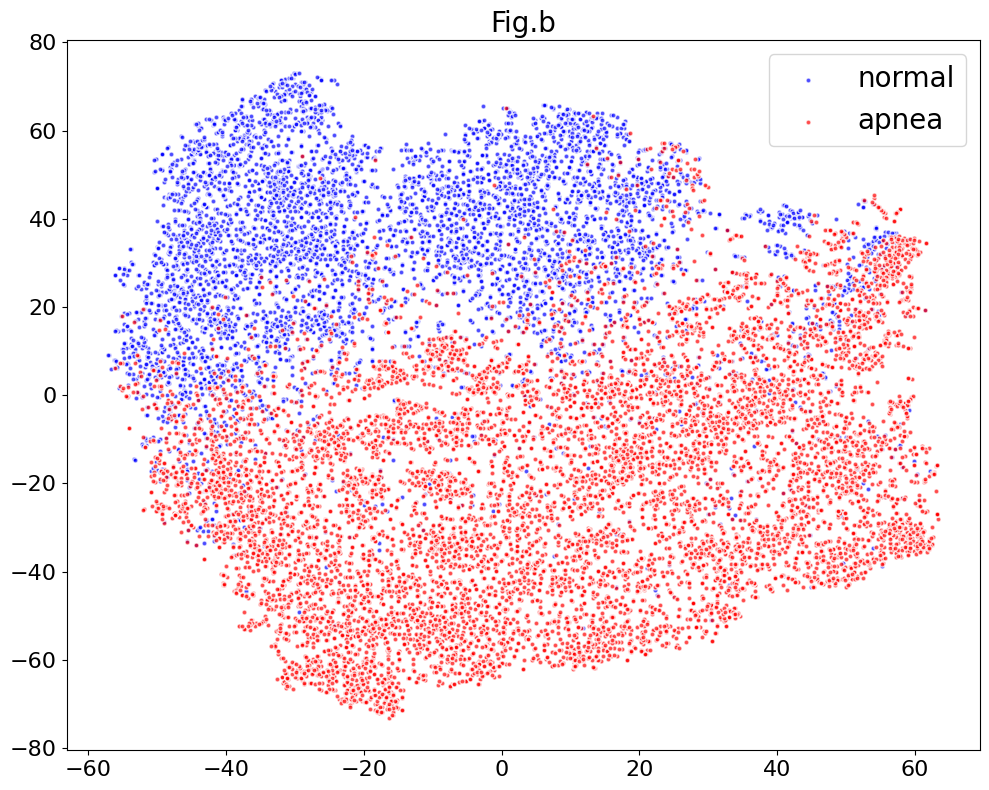

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 假设我们只想可视化Concatenation层的输出  
# model_for_visualization = create_model(x_train1.shape[1:], x_train2.shape[1:], x_train3.shape[1:])
# model_for_visualization=Model(inputs=model_for_visualization.input,outputs=model_for_visualization.get_layer("Feature_Extraction").output)
# model_for_visualization.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
# model_for_visualization.fit([x_train1, x_train2, x_train3], y_train,epochs=10,batch_size=32,validation_split=0.2)


model_for_feature_extraction=Model(inputs=model.input,outputs=model.get_layer("Concat_Layer").output)
# features=model.predict([x_test1, x_test2, x_test3]) 
# 获取Concatenation层的输出  
features = model_for_feature_extraction.predict([x_test1, x_test2, x_test3]) 


# Step 2: 将数据降至二维
features = np.reshape(features, (features.shape[0], -1))
# print(features)

# Step 3: 将多维标签数组转换成一维数组，并将每个标签表示为字符串
labels_str = []
for label in y_test:
    if label[0] == 0 and label[1] == 1:
        labels_str.append('normal')
    elif label[0] == 1 and label[1] == 0:
        labels_str.append('apnea')
    else:
        # 处理未知标签情况
        labels_str.append('Unknown')

# 转换为 NumPy 数组
labels_str = np.array(labels_str)

# Step 4: 应用 t-SNE
# tsne = TSNE(n_components=2, random_state=42,perplexity=40)
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(features)

# Step 5: 绘制散点图
plt.figure(figsize=(10, 8))
plt.scatter(data_tsne[labels_str == 'normal', 0], data_tsne[labels_str == 'normal', 1], color='blue', label='normal',  marker='.', alpha=0.7, s=50, edgecolors='white')
plt.scatter(data_tsne[labels_str == 'apnea', 0], data_tsne[labels_str == 'apnea', 1], color='red', label='apnea',  marker='.', alpha=0.7, s=50, edgecolors='white')
# plt.title("Results with SFE-CBAM(b)", fontsize=20)
plt.title("Fig.b", fontsize=20)
plt.legend(fontsize=20)
# plt.xlabel('Feature dimension 1', fontsize=20)          # 设置x轴标签字体大小
# plt.ylabel('Feature dimension 2', fontsize=20)       # 设置y轴标签字体大小
# 设置x轴和y轴刻度的字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('resultWithModel.png')
# plt.savefig('resultWithoutModel.png')
# plt.savefig('figb.pdf', format='pdf')
# plt.savefig('resultWithModel.pdf', format='pdf')
plt.show()



#特征重要程度





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# # Step 1: 加载without数据集和标签
# data = np.load('datamatrixCBAM.npy')
# labels = np.load('labelmatrixCBAM.npy')

# 加载with数据集
# data = np.load('data3.npy')
# labels = np.load('label3.npy')

# Step 2: 将数据降至二维
data_flat = np.reshape(x_test1, (x_test1.shape[0], -1))

# Step 3: 将多维标签数组转换成一维数组，并将每个标签表示为字符串
labels_str = []
for label in y_test:
    if label[0] == 0 and label[1] == 1:
        labels_str.append('N')
    elif label[0] == 1 and label[1] == 0:
        labels_str.append('A')
    else:
        # 处理未知标签情况
        labels_str.append('Unknown')

# 转换为 NumPy 数组
labels_str = np.array(labels_str)

# Step 4: 应用 t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_flat)

# Step 5: 绘制散点图
plt.figure(figsize=(10, 8))
plt.scatter(data_tsne[labels_str == 'N', 0], data_tsne[labels_str == 'N', 1], color='blue', label='N',  marker='.', alpha=0.7, s=50, edgecolors='white')
plt.scatter(data_tsne[labels_str == 'A', 0], data_tsne[labels_str == 'A', 1], color='red', label='A',  marker='.', alpha=0.7, s=50, edgecolors='white')
# plt.title("Results with SFE-CBAM(b)", fontsize=20)
plt.title("resultWithoutModel", fontsize=20)
plt.legend(fontsize=20)
plt.xlabel('Feature dimension 1', fontsize=20)          # 设置x轴标签字体大小
plt.ylabel('Feature dimension 2', fontsize=20)       # 设置y轴标签字体大小
# 设置x轴和y轴刻度的字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('resultWithModel.png')
# plt.savefig('resultWithoutModel.png')
# plt.savefig('resultWithoutModel.pdf', format='pdf')
# plt.savefig('resultWithModel.pdf', format='pdf')
plt.show()


530/530 [==============================] - 2s 4ms/step - loss: 0.2903 - accuracy: 0.9261
Test loss:  0.29028359055519104
Accuracy:  0.9261182546615601
Testing:
17/17 [==============================] - 0s 14ms/step


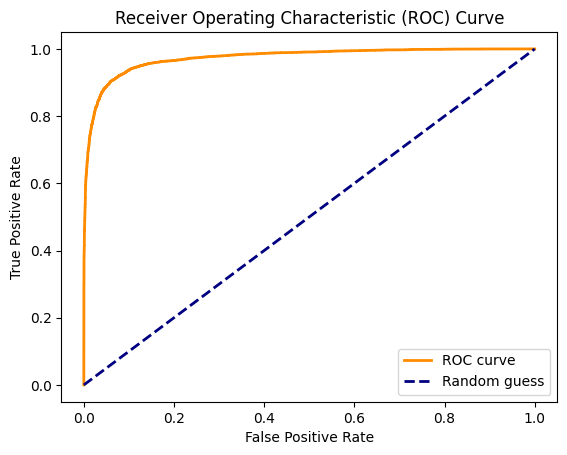

TP:5841, TN:9853, FP:602, FN:650, loss0.29028359055519104, acc0.9261182579959872, sn0.8998613464797411, sp0.9424198947871831, f10.9032008659347458, roc_auc0.9733348149860739


In [29]:
from sklearn.metrics import roc_curve, roc_auc_score


# 评估模型
loss, accuracy = model.evaluate([x_test1, x_test2, x_test3], y_test)
print("Test loss: ", loss)
print("Accuracy: ", accuracy)

# 评估指标
print("Testing:")
y_true, y_pred_prob = y_test.argmax(axis=-1), model.predict([x_test1, x_test2, x_test3], batch_size=1024, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=-1)

# 计算不同阈值下的 TPR 和 FPR
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 计算 ROC AUC
roc_auc = roc_auc_score(to_categorical(y_true, num_classes=2), y_pred_prob)

# 计算混淆矩阵
C = confusion_matrix(y_true, y_pred)

# 计算其他指标
TP, TN, FP, FN = C[1, 1], C[0, 0], C[0, 1], C[1, 0]
acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
precision = TP / (TP + FP)
recall = sn  # Recall is equivalent to sensitivity
f1 = 2 * (precision * recall) / (precision + recall)

# 打印结果
print("TP:{}, TN:{}, FP:{}, FN:{}, loss{}, acc{}, sn{}, sp{}, f1{}, roc_auc{}".format(TP, TN, FP, FN, loss, acc, sn, sp, f1, roc_auc))
